In [1]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker as mticker
from sqlalchemy import PickleType

import sys
sys.path.append("../")
from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types


sns.set_theme()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [2]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

In [3]:
con = sql.connect("benchmarks.db")

In [4]:
con.cursor().execute("SELECT name FROM sqlite_master where type = 'table'").fetchall()

[('camel_scan',)]

In [5]:
df = read_pkl_sql("benchmarks.db", "camel_scan", dtypes=dtypes)
df.columns = df.columns.astype(str)

In [6]:
pwd

'/scratch/ndeutsch/zunis/zunis/experiments/benchmarks/benchmarks_02'

In [7]:
d_sigmas = pd.read_csv('../benchmarks_01/gaussian_camel_integrands.csv')
d_sigmas.head()

,d,sigma_1d,relative_std_camel,sigma_camel,relative_std_gauss,sigma_gauss
0,2.0,0.001,14.105713,0.019974,19.948490,0.019974
1,4.0,0.001,14.105713,0.089272,19.948490,0.089265
2,8.0,0.001,14.105713,0.203943,19.948490,0.188778
3,16.0,0.001,14.105713,0.361255,19.948490,0.280880
4,2.0,0.010,4.409888,0.063162,6.236524,0.063162


In [8]:
d_sigma_camel = d_sigmas[['d','sigma_camel','sigma_1d','relative_std_camel']].rename(columns=
                                                                     {
                                                                         "sigma_camel":'s',
                                                                         'relative_std_camel':'relative_std'
                                                                     })
d_sigma_camel.head()

,d,s,sigma_1d,relative_std
0,2.0,0.019974,0.001,14.105713
1,4.0,0.089272,0.001,14.105713
2,8.0,0.203943,0.001,14.105713
3,16.0,0.361255,0.001,14.105713
4,2.0,0.063162,0.010,4.409888


In [9]:
df_with_1d_s = df.merge(d_sigma_camel,on=["d","s"],how="left")

In [10]:
print(df_with_1d_s["sigma_1d"].isna().sum())
print(df_with_1d_s["relative_std"].isna().sum())

0
0


In [11]:
for k in ["value","flat_target","vegas_target","exact_target"]:
    print(k,df_with_1d_s[k].isna().sum())

value 289
flat_target 281
vegas_target 281
exact_target 281


In [12]:
df_with_1d_s = df_with_1d_s.dropna(subset=["value","flat_target","vegas_target","exact_target"])

In [13]:
matched = df_with_1d_s[df_with_1d_s["exact_match"]]
matched = matched.assign(lvr=matched["vegas_variance_ratio"].apply(np.log10),
              lval=matched["value"].apply(np.log10))
matched = matched.assign(d_cat = matched["d"].astype(str))
matched = matched.sort_values("vegas_variance_ratio",ascending=False)
better = matched.groupby(["d","s"]).head(20)
best = matched.groupby(["d","s"]).head(1)

In [14]:
df2 = matched.set_index(["d","sigma_1d"])
df2.loc[16].index.unique()

Float64Index([0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0], dtype='float64', name='sigma_1d')

<ipython-input-15-fa155e4ffdd5>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax=sns.histplot(data=df2.loc[(32,0.1)],x="lvr", hue=df2.loc[(32,0.1),"lvr"]>0,multiple="stack")
/scratch/ndeutsch/zunis/zunis.v/lib/python3.8/site-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


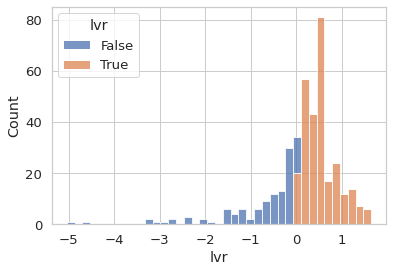

In [15]:
ax=sns.histplot(data=df2.loc[(32,0.1)],x="lvr", hue=df2.loc[(32,0.1),"lvr"]>0,multiple="stack")
plt.show()

In [16]:
clean_matched = matched.replace([np.inf, -np.inf], np.nan).dropna(subset=["lvr"])
clean_better = better.replace([np.inf, -np.inf], np.nan).dropna(subset=["lvr"])

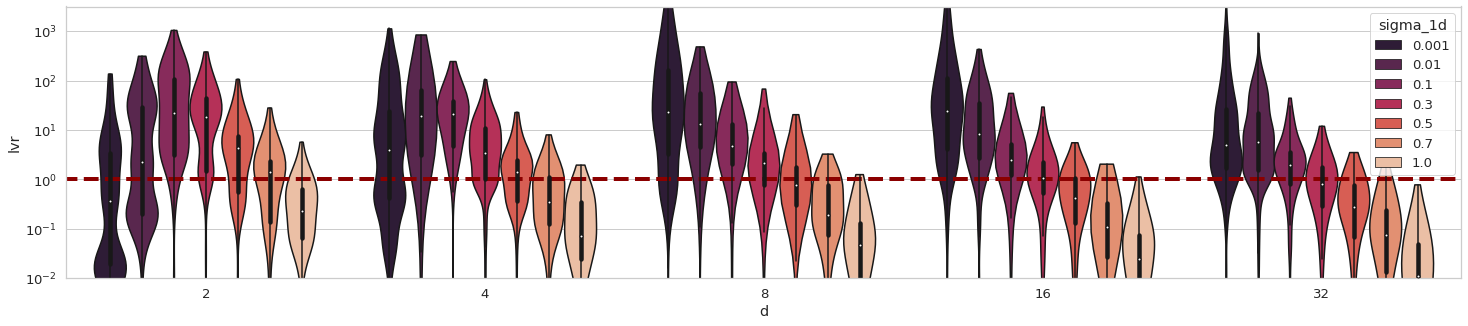

In [17]:
fig, ax = plt.subplots()
ax.plot([-1,5],[0,0],c="darkred",ls="--",lw=4,zorder=1)
sns.violinplot(data=clean_matched, x="d",y="lvr", scale="width", hue="sigma_1d", cut=0 ,palette="rocket", ax=ax)
ax.set(ylim=[-2,3.5])
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-2, 4, 1.0))
fig.set_size_inches(25,5)
plt.show()

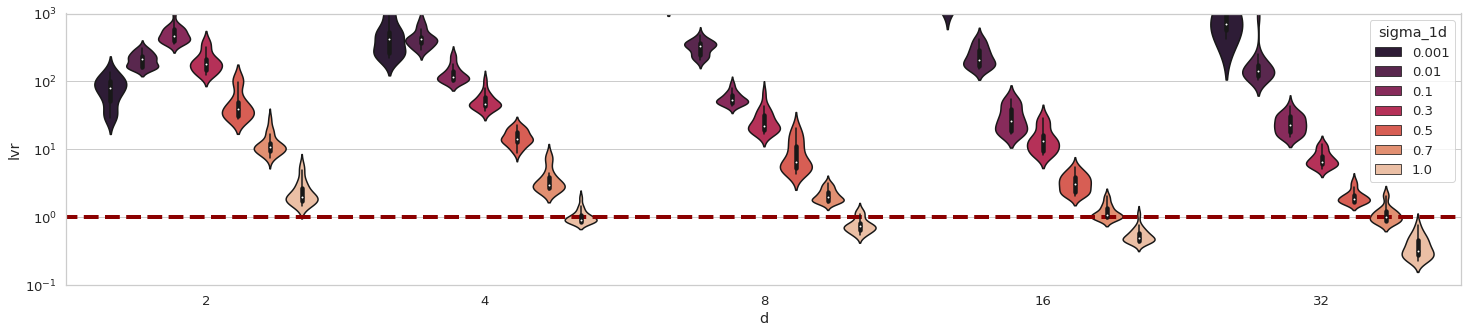

In [18]:
fig, ax = plt.subplots()
ax.plot([-1,5],[0,0],c="darkred",ls="--",lw=4,zorder=1)
sns.violinplot(data=clean_better, x="d",y="lvr", scale="width", hue="sigma_1d" ,palette="rocket", ax=ax)
ax.set(ylim=[-1,3])
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-1, 4, 1.0))
fig.set_size_inches(25,5)
plt.show()

In [19]:
clean_matched["improved"] = clean_matched["vegas_variance_ratio"]>1
clean_better["improved"] = clean_better["vegas_variance_ratio"]>1

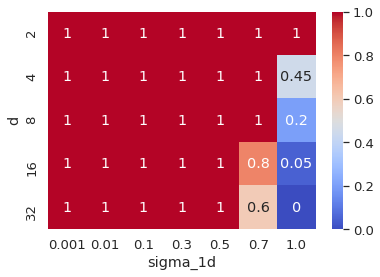

In [20]:
data = clean_better.groupby(["d","sigma_1d"])["improved"].mean().reset_index().pivot("d","sigma_1d","improved")
sns.heatmap(data,cmap="coolwarm", annot=True)
plt.show()

In [21]:
cb = clean_better.groupby(["d","sigma_1d"])

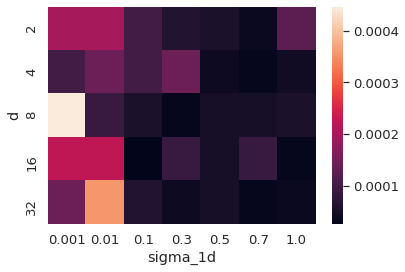

In [22]:
x1 = clean_better.assign(llr = clean_better["lr"].\
                    apply(np.log10)).groupby(["d","sigma_1d"])\
["llr"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","llr").apply(lambda x: 10**x))
plt.show()

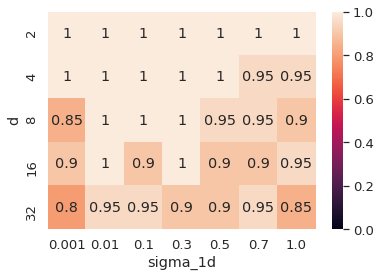

In [23]:
x1 = clean_better.assign(quadfrac = (clean_better["flow"] == "pwquad"))\
.groupby(["d","sigma_1d"])\
["quadfrac"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","quadfrac"),annot=True, vmin=0, vmax=1)
plt.show()

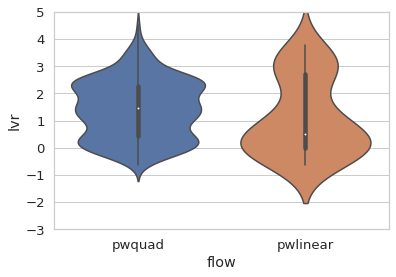

In [29]:
ax = sns.violinplot(data=clean_better,x="flow",y="lvr")
ax.set(ylim=[-3,5])
plt.show()

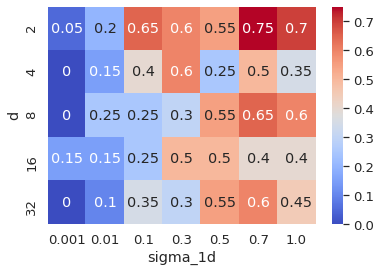

In [30]:
x1 = clean_better.assign(varfrac = (clean_better["loss"] == "variance"))\
.groupby(["d","sigma_1d"])\
["varfrac"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","varfrac"),annot=True, cmap="coolwarm")
plt.show()

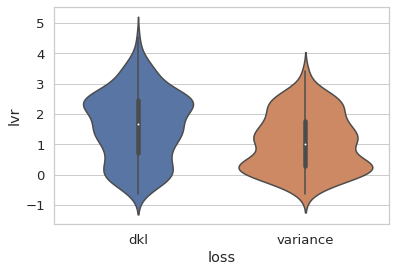

In [31]:
sns.violinplot(data=clean_better,x="loss",y="lvr")
plt.show()

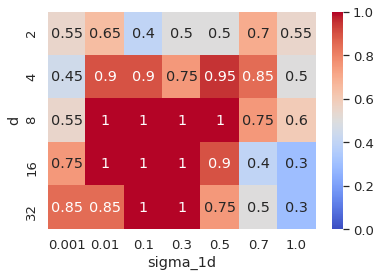

In [32]:
x1 = clean_better.assign(iflowfrac = (clean_better["masking"] == "iflow"))\
.groupby(["d","sigma_1d"])\
["iflowfrac"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","iflowfrac"),annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.show()

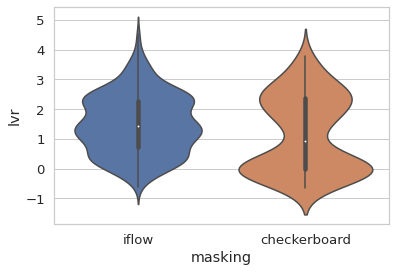

In [33]:
sns.violinplot(data=clean_better,x="masking",y="lvr")
plt.show()

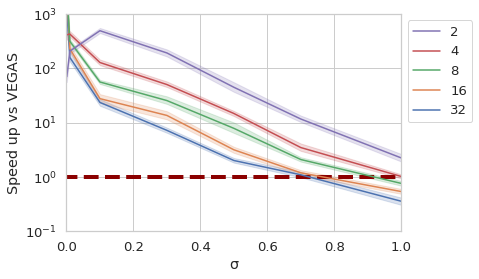

In [34]:
fig,ax = plt.subplots()
ax.plot([-1,5],[0,0],c="darkred",ls="--",lw=4,zorder=1)
sns.lineplot(data=clean_better,x="sigma_1d",y="lvr",hue="d_cat", ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-1, 4, 1.0))
ax.set(
    xlim=[0,1],
    ylim = [-1,3],
    xlabel="σ",
    ylabel='Speed up vs VEGAS'
)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0])))
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1., 1))

plt.show()

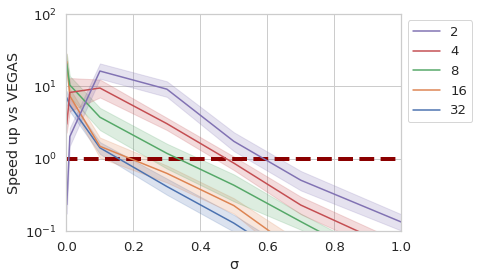

In [38]:
fig,ax = plt.subplots()
ax.plot([-1,5],[0,0],c="darkred",ls="--",lw=4,zorder=1)
sns.lineplot(data=clean_matched,x="sigma_1d",y="lvr",hue="d_cat", ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-1, 3, 1.0))
ax.set(
    xlim=[0,1],
    ylim = [-1,2],
    xlabel="σ",
    ylabel='Speed up vs VEGAS'
)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0])))
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1., 1))

plt.show()

In [40]:
clean_better.columns

Index(['value', 'value_std', 'value_history', 'target_history', 'flat_target',
       'flat_target_std', 'flat_sigma_cutoff', 'flat_sigmas_off',
       'flat_percent_difference', 'flat_variance_ratio', 'flat_match',
       'vegas_target', 'vegas_target_std', 'vegas_sigma_cutoff',
       'vegas_sigmas_off', 'vegas_percent_difference', 'vegas_variance_ratio',
       'vegas_match', 'exact_target', 'exact_target_std', 'exact_sigma_cutoff',
       'exact_sigmas_off', 'exact_percent_difference', 'exact_variance_ratio',
       'exact_match', 'flow', 'd_hidden', 'n_bins', 'n_hidden', 'masking',
       'repetitions', 'loss', 'n_points_survey', 'n_iter', 'minibatch_size',
       'max_reloads', 'n_epochs', 'optim_cls', 'betas', 'eps', 'lr',
       'checkpoint', 'checkpoint_on_cuda', 'checkpoint_path',
       'survey_strategy', 's', 'norm', 'd', 'time_zunis', 'time_vegas',
       'git_info', 'extra_data', 'sigma_1d', 'relative_std', 'lvr', 'lval',
       'd_cat', 'improved'],
      dtype='object')

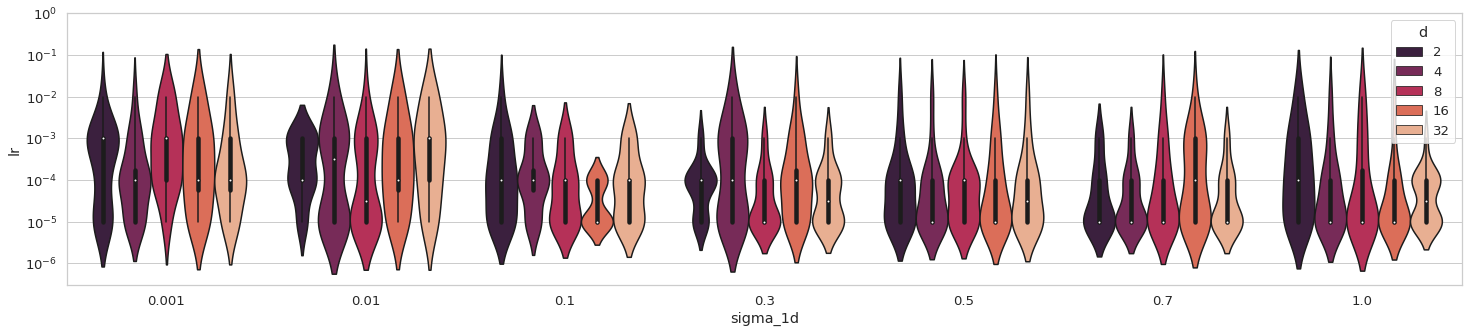

In [57]:
fig, ax = plt.subplots()
sns.violinplot(data=clean_better, x="sigma_1d",y=np.log(clean_better["lr"])/np.log(10.), scale="width", hue="d" ,palette="rocket", ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-6, 1.0))
fig.set_size_inches(25,5)
plt.show()

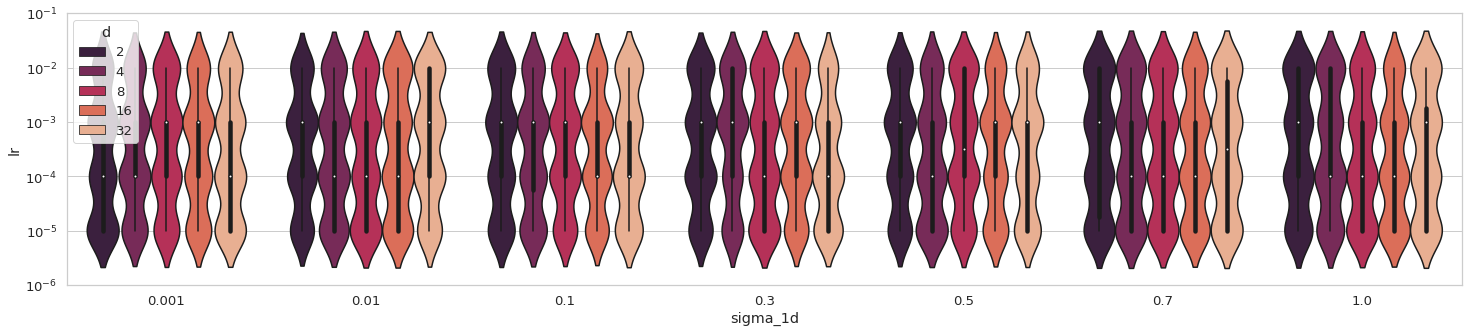

In [56]:
fig, ax = plt.subplots()
sns.violinplot(data=clean_matched, x="sigma_1d",y=np.log(clean_matched["lr"])/np.log(10), scale="width", hue="d" ,palette="rocket", ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.yticks(np.arange(-6, 0, 1.0))
fig.set_size_inches(25,5)
plt.show()

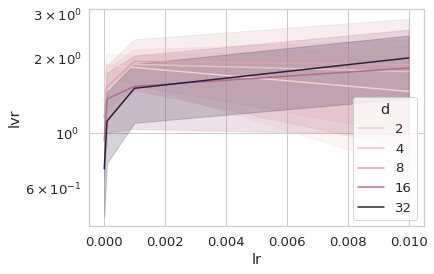

In [65]:
fig, ax = plt.subplots()
sns.lineplot(data=clean_better, x='lr', y='lvr',ax=ax,  hue='d')
ax.set(yscale='log')
plt.show()

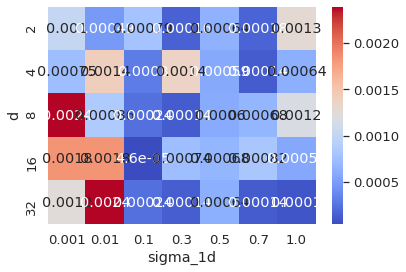

In [66]:
x1 = clean_better\
.groupby(["d","sigma_1d"])\
["lr"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","lr"),annot=True, cmap="coolwarm")
plt.show()

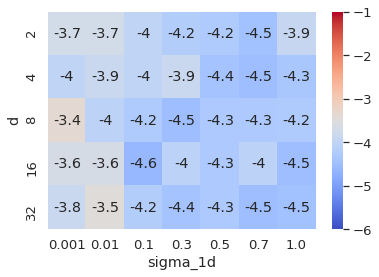

In [75]:
x1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","lr"),annot=True, cmap="coolwarm", vmin=-6, vmax=-1)
plt.show()

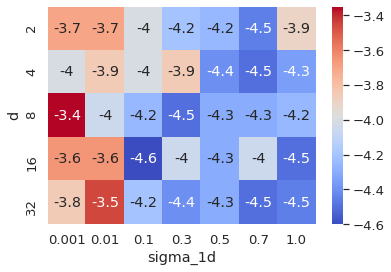

In [87]:
x1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].mean()
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","lr"),annot=True, cmap="coolwarm")
plt.show()

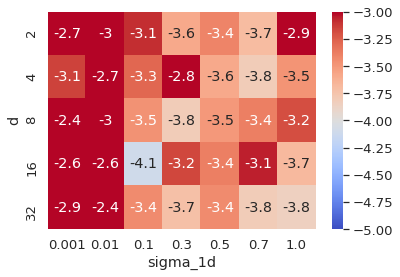

In [86]:
x1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].mean()
dx1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].std()
x1 = x1+dx1
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","lr"),annot=True, cmap="coolwarm", vmin=-5, vmax=-3)
plt.show()

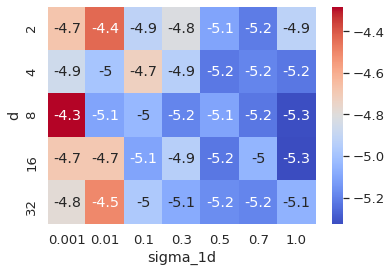

In [74]:
x1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].mean()
dx1 = clean_better.assign(lr=np.log(clean_better['lr'])/np.log(10))\
.groupby(["d","sigma_1d"])\
["lr"].std()
x1 = x1-dx1
sns.heatmap(x1.reset_index().pivot("d","sigma_1d","lr"),annot=True, cmap="coolwarm")
plt.show()